# Baseline Tests

Here we test some standard models like random forest and naive Bayes to establish some baseline for the project.

In [56]:
import os

import imageio
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB

from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = "data"

selected_columns = ["Type", "Age", "Breed1", "Breed2", "Gender", "Color1", "Color2", "Color3",
                    "MaturitySize", "FurLength", "Vaccinated", "Dewormed", "Sterilized", "Health",
                    "Quantity", "Fee", "State", "VideoAmt", "PhotoAmt"]

label_column = "AdoptionSpeed"

In [3]:
# Read train.csv
# TODO: rm n-rows
train = pd.read_csv(os.path.join(data_dir, "train.csv"), sep=',')
pet_ids = train["PetID"]

In [4]:
y = train["AdoptionSpeed"]
X = train[selected_columns]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [6]:
def normalize(df, columns):
    result = df.copy()
    for feature_name in columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [7]:
X_train_norm = normalize(X_train, ["Age", "Fee"]) #, "Quantity", "VideoAmt", "PhotoAmt"])
X_test_norm = normalize(X_test, ["Age", "Fee"]) # ,"Quantity", "VideoAmt", "PhotoAmt"])

In [8]:
X_dummies = pd.get_dummies(X, columns=["Type", "Breed1", "Breed2", "Gender", "Color1", "Color2", "Color3", "MaturitySize", 
                                       "FurLength", "Vaccinated", "Dewormed", "Sterilized", "Health", "State"])

In [9]:
X_train_dummies, X_test_dummies, y_train, y_test = train_test_split(X_dummies, y, test_size=0.3, random_state=1)

In [10]:
X_train_dummies.head()

,Age,Quantity,Fee,VideoAmt,PhotoAmt,Type_1,Type_2,Breed1_0,Breed1_1,Breed1_3,...,State_41330,State_41332,State_41335,State_41336,State_41342,State_41345,State_41361,State_41367,State_41401,State_41415
11539,2,1,0,0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6945,1,1,30,0,7.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12403,1,1,0,0,2.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3259,7,2,500,0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1125,10,1,110,0,2.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
# importances = forest.feature_importances_

# Code taken from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
def plot_feature_importances(forest, importances, features):
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    print("Feature list:", list(features))
    print()

    # Print the feature ranking
    print("Feature ranking:")
    
    n_features = len(features)
    for i in range(n_features): # range(X.shape[1]):
        print("%d. feature %s (%f)" % (i + 1, features[indices[i]], importances[indices[i]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(n_features), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(n_features), indices)
    plt.xlim([-1, n_features])
    plt.show()

## 1. Random Forest

First, try changing n_estimators to find the best one according to test score.

In [7]:
best_test_score = -1
best_n = None

for n in range(5, 101, 5):
    rf = RandomForestClassifier(n_estimators=n).fit(X_train, y_train)
    pred_test = rf.predict(X_test)
    pred_train = rf.predict(X_train)
    cohen_kappa = cohen_kappa_score(y_test, pred_test, weights="quadratic")
    train_score = accuracy_score(y_train, pred_train)
    test_score = accuracy_score(y_test, pred_test)
    print(n)
    print("cohen kappa =", cohen_kappa)
    print("train score =", train_score)
    print("test score =", test_score)
    
    if best_test_score < test_score:
        best_test_score = test_score
        best_n = n

5
cohen kappa = 0.24215763791456768
train score = 0.9202477370176274
test score = 0.3425967096487328
10
cohen kappa = 0.2820327020645549
train score = 0.9740828966174369
test score = 0.36460649177412185
15
cohen kappa = 0.2821226087660422
train score = 0.9819914244878514
test score = 0.3721654068474878
20
cohen kappa = 0.3107020300302489
train score = 0.9843735111958075
test score = 0.38861716318363715
25
cohen kappa = 0.30638513401266465
train score = 0.984945212005717
test score = 0.3850600266785238
30
cohen kappa = 0.30239795511426737
train score = 0.9858980466888995
test score = 0.3828368163628279
35
cohen kappa = 0.30344759689124245
train score = 0.986088613625536
test score = 0.3830591373943975
40
cohen kappa = 0.31392828235136927
train score = 0.986088613625536
test score = 0.3897287683414851
45
cohen kappa = 0.2943494838795222
train score = 0.986088613625536
test score = 0.3808359270787016
50
cohen kappa = 0.31605036816702214
train score = 0.9861838970938542
test score = 0.3852

In [8]:
print(best_n)
print(round(best_test_score, 4))

70
0.3993


Next, try different n_estimators and max_depth values.

In [9]:
best_test_score = -1
best_test_params = None
best_ckappa = -1
best_ckappa_params = None
best_cv_score = -1
best_cv_params = None

for n in range(5, 101, 5):
    for d in range(5, 31, 5):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d)
        # Run cross-validation, get scores
        cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
        # Get test scores
        rf.fit(X_train, y_train)
        pred_test = rf.predict(X_test)
        test_score = accuracy_score(y_test, pred_test)
        # Get the cohen kappa score
        cohen_kappa = cohen_kappa_score(y_test, pred_test, weights="quadratic")
        
        print("n_estimators=%d, max_depth=%d" % (n, d))
        print("cohen kappa", round(cohen_kappa, 4))
        print("cross-val acc %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))
        print("test acc", round(test_score, 4))

        # Update best scores and parameters
        if best_test_score < test_score:
            best_test_score = test_score
            best_test_params = (n, d)
        
        if best_ckappa < cohen_kappa:
            best_ckappa = cohen_kappa
            best_ckappa_params = (n, d)
        
        if best_cv_score < cv_scores.mean():
            best_cv_score = cv_scores.mean()
            best_cv_params = (n, d)

n_estimators=5, max_depth=5
cohen kappa 0.2549
cross-val acc 0.37 (+/- 0.02)
test acc 0.3746
n_estimators=5, max_depth=10
cohen kappa 0.2986
cross-val acc 0.37 (+/- 0.02)
test acc 0.3853
n_estimators=5, max_depth=15
cohen kappa 0.2422
cross-val acc 0.36 (+/- 0.02)
test acc 0.3559
n_estimators=5, max_depth=20
cohen kappa 0.2652
cross-val acc 0.35 (+/- 0.02)
test acc 0.3544
n_estimators=5, max_depth=25
cohen kappa 0.223
cross-val acc 0.35 (+/- 0.01)
test acc 0.3422
n_estimators=5, max_depth=30
cohen kappa 0.246
cross-val acc 0.34 (+/- 0.03)
test acc 0.3379
n_estimators=10, max_depth=5
cohen kappa 0.2154
cross-val acc 0.38 (+/- 0.02)
test acc 0.3682
n_estimators=10, max_depth=10
cohen kappa 0.3155
cross-val acc 0.39 (+/- 0.02)
test acc 0.3897
n_estimators=10, max_depth=15
cohen kappa 0.29
cross-val acc 0.38 (+/- 0.01)
test acc 0.3757
n_estimators=10, max_depth=20
cohen kappa 0.3016
cross-val acc 0.37 (+/- 0.02)
test acc 0.3768
n_estimators=10, max_depth=25
cohen kappa 0.2866
cross-val acc

In [11]:
print(best_test_params)
print(round(best_test_score, 4))
print(best_ckappa_params)
print(round(best_ckappa, 4))
print(best_cv_params)
print(round(best_cv_score, 4))

(65, 15)
0.4055
(65, 15)
0.346
(70, 15)
0.4131


Use the best test score parameters and normalized data.

In [70]:
rf = RandomForestClassifier(n_estimators=65, max_depth=15)
print(cross_val_score(rf, X_train_norm, y_train, cv=5).mean())
rf.fit(X_train_norm, y_train)
pred_test = rf.predict(X_test_norm)
print(accuracy_score(y_test, test_pred))
print(cohen_kappa_score(y_test, pred_test, weights="quadratic"))

0.41267219469956357
0.3839484215206759
0.2771982337792719


Use the best test score parameters and one-hot-encoded data.

In [71]:
rf = RandomForestClassifier(n_estimators=65, max_depth=15)
print(cross_val_score(rf, X_train_dummies, y_train, cv=5).mean())
rf.fit(X_train_dummies, y_train)
pred_test = rf.predict(X_test_dummies)
print(accuracy_score(y_test, pred_test))
print(cohen_kappa_score(y_test, pred_test, weights="quadratic"))

0.40219192017036925
0.3901734104046243
0.30113085076834245


Use sklearn.svm.LinearSVC with sklearn.feature_selection.SelectFromModel to evaluate feature importances and select the most relevant features. Then train an sklearn.ensemble.RandomForestClassifier using only relevant features. 

In [72]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, max_iter=2500))),
  ('classification', RandomForestClassifier(n_estimators=65, max_depth=15))
])
print(cross_val_score(clf, X_train_norm, y_train, cv=5).mean())
clf.fit(X_train_norm, y_train)
pred_test = clf.predict(X_test_norm)
print(accuracy_score(y_test, pred_test))
print(cohen_kappa_score(y_test, pred_test, weights="quadratic"))

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.40390711364903353


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.3897287683414851
0.29165630402327136


In [47]:
X_train_norm.columns # 19 features in total

Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt',
       'PhotoAmt'],
      dtype='object')

We can look at the features that were shown and we see that the SelectFromModel with LinearSVC did not actually eliminate any feature.

In [34]:
feature_idx = clf.named_steps.feature_selection.get_support()
X_train_norm.columns[feature_idx] 

Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt',
       'PhotoAmt'],
      dtype='object')

Let's also try feature selection with SelectKBest and f_regression, using different values of k < 19.

In [73]:
kbest_filter = SelectKBest(f_regression, k=5)
rf = RandomForestClassifier(n_estimators=65, max_depth=15)
rf_kbest = Pipeline([('kbest', kbest_filter), ('rf', rf)])

print(cross_val_score(rf_kbest, X_train_norm, y_train, cv=5).mean())
rf_kbest.fit(X_train_norm, y_train)
pred_test = rf_kbest.predict(X_test_norm)
print(accuracy_score(y_test, pred_test))
print(cohen_kappa_score(y_test, pred_test, weights="quadratic"))

0.3545519971281305
0.3479324144064028
0.21948494143948605


In [74]:
kbest_filter = SelectKBest(f_regression, k=10)
rf = RandomForestClassifier(n_estimators=65, max_depth=15)
rf_kbest = Pipeline([('kbest', kbest_filter), ('rf', rf)])

print(cross_val_score(rf_kbest, X_train_norm, y_train, cv=5).mean())
rf_kbest.fit(X_train_norm, y_train)
pred_test = rf_kbest.predict(X_test_norm)
print(accuracy_score(y_test, pred_test))
print(cohen_kappa_score(y_test, pred_test, weights="quadratic"))

0.36445902768690003
0.3485993775011116
0.23011657507164684


In [75]:
kbest_filter = SelectKBest(f_regression, k=15)
rf = RandomForestClassifier(n_estimators=65, max_depth=15)
rf_kbest = Pipeline([('kbest', kbest_filter), ('rf', rf)])

print(cross_val_score(rf_kbest, X_train_norm, y_train, cv=5).mean())
rf_kbest.fit(X_train_norm, y_train)
pred_test = rf_kbest.predict(X_test_norm)
print(accuracy_score(y_test, pred_test))
print(cohen_kappa_score(y_test, pred_test, weights="quadratic"))

0.3953302842104428
0.37950200088928415
0.2801887783594732


In [76]:
feature_idx = rf_kbest.named_steps.kbest.get_support()
X_train_norm.columns[feature_idx] 

Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
       'Health', 'Quantity', 'PhotoAmt'],
      dtype='object')

In [77]:
kbest_filter = SelectKBest(f_regression, k=13)
rf = RandomForestClassifier(n_estimators=65, max_depth=15)
rf_kbest = Pipeline([('kbest', kbest_filter), ('rf', rf)])

print(cross_val_score(rf_kbest, X_train_norm, y_train, cv=5).mean())
rf_kbest.fit(X_train_norm, y_train)
pred_test = rf_kbest.predict(X_test_norm)
print(accuracy_score(y_test, pred_test))
print(cohen_kappa_score(y_test, pred_test, weights="quadratic"))

0.38390021698410415
0.3599377501111605
0.26091047206007334


In [78]:
kbest_filter = SelectKBest(f_regression, k=17)
rf = RandomForestClassifier(n_estimators=65, max_depth=15)
rf_kbest = Pipeline([('kbest', kbest_filter), ('rf', rf)])

print(cross_val_score(rf_kbest, X_train_norm, y_train, cv=5).mean())
rf_kbest.fit(X_train_norm, y_train)
pred_test = rf_kbest.predict(X_test_norm)
print(accuracy_score(y_test, pred_test))
print(cohen_kappa_score(y_test, pred_test, weights="quadratic"))

0.4037152755308407
0.38372610048910627
0.2719489985916099


In [79]:
kbest_filter = SelectKBest(f_regression, k=18)
rf = RandomForestClassifier(n_estimators=65, max_depth=15)
rf_kbest = Pipeline([('kbest', kbest_filter), ('rf', rf)])

print(cross_val_score(rf_kbest, X_train_norm, y_train, cv=5).mean())
rf_kbest.fit(X_train_norm, y_train)
pred_test = rf_kbest.predict(X_test_norm)
print(accuracy_score(y_test, pred_test))
print(cohen_kappa_score(y_test, pred_test, weights="quadratic"))

0.4135312892479576
0.38861716318363715
0.280300678540088


We can also plot feature importances from the random forest model.

Feature list: ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'PhotoAmt']

Feature ranking:
1. feature Age (0.140424)
2. feature PhotoAmt (0.120097)
3. feature Breed1 (0.094047)
4. feature Color1 (0.069715)
5. feature Color2 (0.068352)
6. feature State (0.062146)
7. feature Breed2 (0.058648)
8. feature Quantity (0.045818)
9. feature Fee (0.044373)
10. feature Gender (0.042972)
11. feature MaturitySize (0.042701)
12. feature FurLength (0.041469)
13. feature Sterilized (0.040933)
14. feature Color3 (0.037233)
15. feature Dewormed (0.033990)
16. feature Vaccinated (0.033978)
17. feature Health (0.011609)
18. feature Type (0.011497)


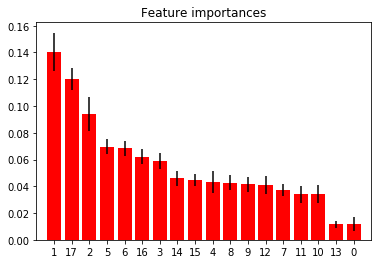

In [80]:
importances = rf_kbest.named_steps.rf.feature_importances_
feature_idx = rf_kbest.named_steps.kbest.get_support()
features = X_train_norm.columns[feature_idx]
plot_feature_importances(rf_kbest.named_steps.rf, importances, features)

## 2. Gaussian Naive Bayes

Try with different types of datasets.

In [11]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
train_pred = gnb.predict(X_train)
test_pred = gnb.predict(X_test)

print(round(accuracy_score(train_pred, y_train), 4))
print(round(accuracy_score(test_pred, y_test), 4))

0.3482
0.3361


In [12]:
gnb = GaussianNB()
gnb.fit(X_train_norm, y_train)
train_pred = gnb.predict(X_train_norm)
test_pred = gnb.predict(X_test_norm)

print(round(accuracy_score(train_pred, y_train), 4))
print(round(accuracy_score(test_pred, y_test), 4))

0.3482
0.3268


In [13]:
gnb = GaussianNB()
gnb.fit(X_train_dummies, y_train)
train_pred = gnb.predict(X_train_dummies)
test_pred = gnb.predict(X_test_dummies)

print(round(accuracy_score(train_pred, y_train), 4))
print(round(accuracy_score(test_pred, y_test), 4))

0.0785
0.0522


## 3. AdaBoost 

In [15]:
ada = AdaBoostClassifier()
ada.fit(X_train_norm, y_train)
train_pred = ada.predict(X_train_norm)
test_pred = ada.predict(X_test_norm)

print(round(accuracy_score(train_pred, y_train), 4))
print(round(accuracy_score(test_pred, y_test), 4))

0.3981
0.3746


In [19]:
confusion_matrix(y_test, test_pred)

array([[  0,  33,  30,   9,  52],
       [  3, 161, 328,  92, 326],
       [  0, 137, 415, 140, 530],
       [  1,  88, 302, 182, 416],
       [  2,  49, 173, 102, 927]], dtype=int64)